# Deterministic Pursuit-Only Dynamics

- The predator accelerates in a straight line towards the prey
- The predator has higher speed than the prey

In [1]:
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
class Agent:
    def __init__(self, pos, vel, acc): # add other properties if needed
        self.pos = np.array(pos, dtype=float)
        self.vel = np.array(vel, dtype=float)
        self.acc = np.array(acc, dtype=float)

    def move(self, dt):
        self.pos += self.vel * dt

    def accelerate(self, dt):
        self.vel += self.acc * dt

In [3]:
class Predator(Agent):
    pass

In [4]:
class Prey(Agent):
    pass

In [5]:
predator = Agent([20, 20], [0.5, 1], [0, 0])
prey = Agent([50, 50], [0, 0.5], [0,0])

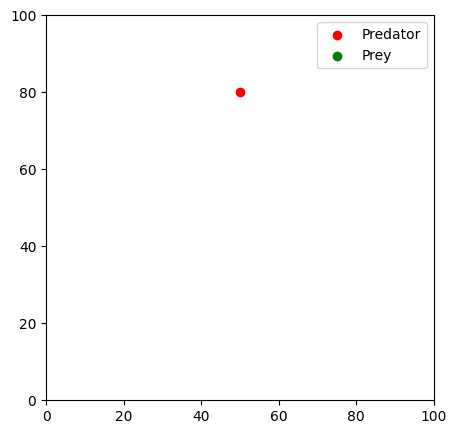

In [6]:
# simulation loop
for _ in range(70):
    predator.move(1)
    prey.move(1)

    # positions
    pred_x, pred_y = predator.pos[0], predator.pos[1]
    prey_x, prey_y = prey.pos[0], prey.pos[1]

    if (predator.pos == prey.pos).all():
        prey.pos = [101, 101]
        predator.vel = [0, 0]

    clear_output(wait=True)
    plt.figure(figsize=(5, 5))
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.scatter(pred_x, pred_y, color='red', label='Predator')
    plt.scatter(prey_x, prey_y, color='green', label='Prey')
    plt.legend()
    plt.show()
    time.sleep(0.3)